In [63]:
from skimage.feature import canny, corner_harris, corner_peaks, corner_fast, corner_subpix, match_descriptors, ORB, plot_matches
from scipy.ndimage.morphology import binary_closing
from skimage.transform import warp, AffineTransform, rotate
from skimage.measure import ransac
import skimage.feature
import cv2
from imageio import imread
from skimage.color import rgb2gray
import os
import csv
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib import cm
import numpy as np

from skimage.morphology import binary_opening
from skimage.filters import threshold_otsu, threshold_minimum, threshold_li, threshold_isodata, threshold_mean 
from skimage.filters import gaussian
from skimage.measure import label


Этот порог будет использоваться для преобразования Кэнни:

In [6]:
treshold = 0.4

# Подготовительная часть

In [7]:
# функция, вычисляющая карту границ от изображения
def preprocess(image_path):
    img = imread(image_path)

    img_gray = rgb2gray(img)
    img_edges = canny(img_gray, sigma=2.7, low_threshold=0.01)

    return binary_closing(img_edges, iterations = 3)

# функция для нахождения особых точек на изображении
def find_keypoints(edge_map, r):
    keypoints = corner_peaks(corner_harris(edge_map), threshold_rel=r)
    return keypoints

Подготовим шаблоны к работе. Во-первых, иногда на картинку попадает край листа. Чтобы на него не реагировало преобразование Кэнни, немного обрежем шаблоны. Затем найдем границы объектов для получившихся зображений и по ним строим минимальный описывающий прямоугольник.

In [8]:
templates = os.listdir('objects')
rectangle = {template: None for template in templates}
crop = {template: None for template in templates}

for template in templates:
    # зачитываем шаблоны
    image = imread(f'objects/{template}')
    w, h = len(image[0]), len(image)
    
    # обрезаем края и сохраняем. теперь будем работать с сохраненными шаблонами
    im = PIL.Image.open(f'objects/{template}')
    im_crop = im.crop((30, 200, w-30, h-200))
    im_crop.save(f'cutted_templates/{template}', quality=95)
    
    # вычисляем края для каждого шаблона
    edges = []
    edge_map = preprocess(f'cutted_templates/{template}')
    
    # описываем вокруг каждого предмета минимальный прямоугольник
    nz = np.nonzero(edge_map)
    edges = np.array(list(zip(nz[0], nz[1])))
    
    rectangle[template] = cv2.minAreaRect(edges)

<ipython-input-7-cd0c23903396>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


Пример описывающего прямоугольника для одного из шаблонов. Пока что он описывает предмет вместе с тенью. Это надо будет исправлять.

<ipython-input-7-cd0c23903396>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


bounding box: [[394 853]
 [702 460]
 [799 536]
 [491 929]]


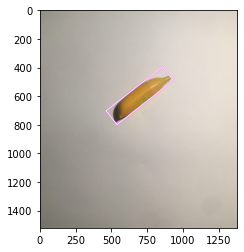

In [27]:
template = imread(f'cutted_templates/{templates[0]}')
edge_map = preprocess(f'cutted_templates/{templates[0]}')
rect = rectangle[templates[0]]
box = cv2.boxPoints(rect)
box = np.int0(box)

boxT=np.vstack((box[:,1],box[:,0]))
boxT=boxT.T

print("bounding box: {}".format(box))
cv2.drawContours(template, [boxT], 0, (255, 0, 255), 5)

plt.imshow(template)

Теперь обрежем шаблоны по построенным прямоугольникам. Я сначала питалась использовать обрезанные изображения для матчинга, но не получилось. Зато по ним удобно вычислять размеры описанного прямоугольника -- они нам понадобятся для геометрической части.

In [38]:
# функция поворачивает изображение, чтобы прямоугольник стал параллелен осям координат
def rotate_image(image, center, angle):
  image_center = center 
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, (image.shape[1::-1]), flags=cv2.INTER_LINEAR)
  return result

In [39]:
poly = {template: None for template in templates}
max_dim = {template: None for template in templates}
for template in templates:
    # зачитываем изображение и соотвествующий прямоугольник
    image = imread(f'cutted_templates/{template}')
    rect = rectangle[template]
    
    # поворачиваем изображение
    r_image = rotate_image(image, (rect[0][1], rect[0][0]),  - rect[2])
    
    # обрезаем по измерениям прямоугольника и сохраняем
    rect_c_x = int(rect[0][0]) 
    rect_c_y = int(rect[0][1])
    rect_w = int(rect[1][0])
    rect_h = int(rect[1][1])
    image_cropped = r_image[rect_c_x-rect_w//2 - 1:rect_c_x+rect_w//2 + 1, rect_c_y - rect_h//2 -1 :rect_c_y+rect_h//2 + 1]
    cv2.imwrite(f'crops/{template}', cv2.cvtColor(image_cropped, cv2.COLOR_RGB2BGR))
    
    # теперь мы знаем измерения описывающего прямоугольника
    # сдвигаем прямоугольник в 0, запоминаем координаты, а также максимальное из измерений
    poly[template] = [[0,0], [0, rect_h], [rect_w, rect_h], [rect_w, 0]]
    max_dim[template] = max(rect_w, rect_h)

Вот пример такой обрезки для для одного из шаблонов.

596
695
123
499


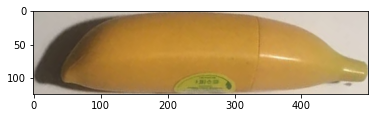

In [45]:
templ = templates[0]
image = imread(f'cutted_templates/{templ}')
rect = rectangle[templ]

angle = rect[0]
r_image = rotate_image(image, (rect[0][1],rect[0][0]),  - rect[2])

rect_c_x = int(rect[0][0]); print(rect_c_x)
rect_c_y = int(rect[0][1]); print(rect_c_y)
rect_w = int(rect[1][0]); print(rect_w)
rect_h = int(rect[1][1]); print(rect_h)

image_cropped = r_image[rect_c_x-rect_w//2 - 1:rect_c_x+rect_w//2 + 1, rect_c_y - rect_h//2 -1 :rect_c_y+rect_h//2 + 1]
plt.imshow(image_cropped)

# Распознавание объектов на фото

С помощью ORB найдем особые точки и их дескрипторы для всех шаблонов, а потом и для входного изображения.

In [54]:
orb = ORB(harris_k = 0.005)

def find_kps_and_des(number):
    # зачитываем изображение
    img_name = os.listdir(f'input/input{number}')[1]
    img = rgb2gray(imread(f'input/input{number}/{img_name}'))
    edge_img = preprocess(f'input/input{number}/{img_name}')
    
    # вычисляем дескрипторы и особые точки
    orb.detect_and_extract(edge_img)
    in_keypoints = orb.keypoints 
    in_descriptors = orb.descriptors
    return edge_img, in_keypoints, in_descriptors


# Находим особые точки и дескрипторы для всех шаблонов
templates = os.listdir('cutted_templates')

kps = {template: None for template in templates}
des = {template: None for template in templates}
edge_map = {template: None for template in templates}

for template in templates:
    edge_map[template] = preprocess((f'cutted_templates/{template}'))
    keypoints = orb.detect_and_extract(edge_map[template])
    kps[template] = orb.keypoints
    des[template] = orb.descriptors    

<ipython-input-7-cd0c23903396>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img_gray = rgb2gray(img)


Для примера вычислим для одного из размеченных изображений.

In [114]:
edge_img, in_keypoints, in_descriptors = find_kps_and_des(0)   

Вот такие соответствия получаются при матчинге. Видно, что для фотоаппарата работает, но для большинства предметов на самом деле получается довольно плохо. (На первой картинке линии соединяют особые точки фотоаппарата на входной картинке с особыми точками шаблона. Во втором ряду границы входного изображения и фотоаппарата)

(-0.5, 1379.5, 1519.5, -0.5)

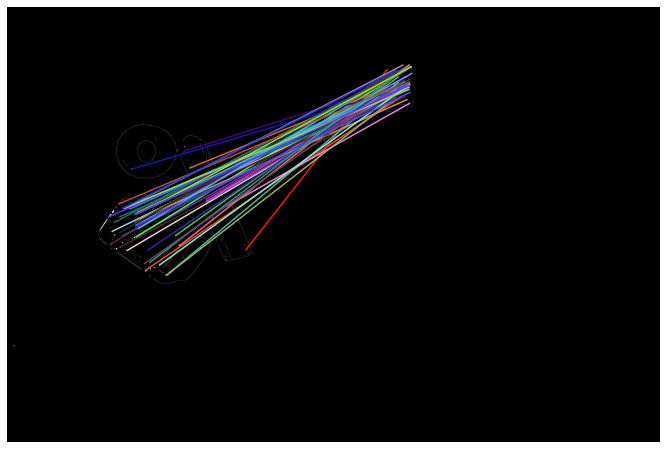

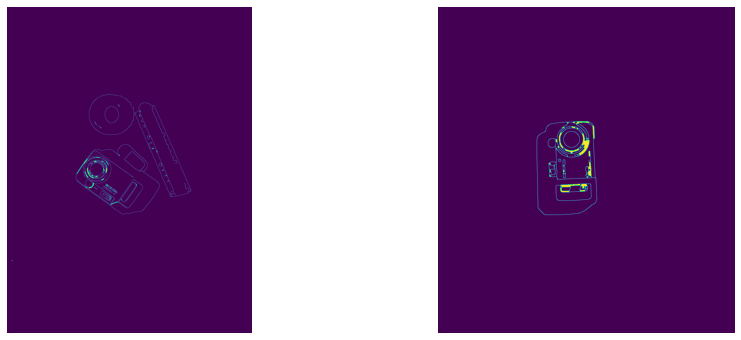

In [61]:
# BFMatcher with default params
matches = match_descriptors(in_descriptors, des[templates[1]], cross_check = True)

fig, ax = plt.subplots(1, 1, figsize=(20,8))

plot_matches(ax, edge_img, edge_map[templates[1]], in_keypoints, kps[templates[1]], matches)
ax.axis('off')

fig, ax = plt.subplots(1, 2, figsize=(15,6))

ax[0].imshow(edge_img)
ax[0].axis('off')


ax[1].imshow(edge_map[templates[1]])
ax[1].axis('off')


Теперь оценим количество предметов на входной картинке. Для этого бинаризуем ее и посчитаем число компонент связности.

In [73]:
# функция бинаризует изобраение и считает компоненты связности
def find_comp_amount(number):
    # зачитываем изображение
    img_name = os.listdir(f'input/input{number}')[1]
    img = rgb2gray(imread(f'input/input{number}/{img_name}'))
    img = img[400: len(img)-400, :]
    
    # слаживаем и оставляем 1 канал
    img_blur = gaussian(img, sigma=3, multichannel=True)
    img_blur_gray = rgb2gray(img_blur)

    # разные методы бинаризации
    thresh_otsu = threshold_otsu(img_blur_gray)
    thresh_min = threshold_minimum(img_blur_gray)
    thresh_li = threshold_li(img_blur_gray)
    thresh_isodata = threshold_isodata(img_blur_gray)
    thresh_mean = threshold_mean(img_blur_gray)
    
    # получаем бинаризованные изображения
    res_otsu = img_blur_gray <= thresh_otsu
    res_min = img_blur_gray <= thresh_min
    res_li = img_blur_gray <= thresh_li
    res_iso = img_blur_gray <= thresh_isodata
    res_mean = img_blur_gray <= thresh_mean

    # применяем морфологические операции для большей четкости
    otsu = binary_opening(res_otsu, selem=np.ones((25, 25)))
    minim = binary_opening(res_min, selem=np.ones((20, 20)))
    li = binary_opening(res_li, selem=np.ones((30, 30)))
    iso = binary_opening(res_iso, selem=np.ones((40, 40)))
    mean = binary_opening(res_mean, selem=np.ones((30, 30)))

    comp_amount = min(label(otsu, return_num = True)[1], 
                      label(minim, return_num = True)[1], 
                      label(li, return_num = True)[1],
                      label(iso, return_num = True)[1], 
                      label(mean, return_num = True)[1])
    return comp_amount, otsu, minim, li, iso, mean

Посмотрим как она работает с размеченным изображением, рассмотренным выше.

<ipython-input-73-87e5f018bcb4>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_blur_gray = rgb2gray(img_blur)


Компонент связности: 6


(-0.5, 3023.5, 3231.5, -0.5)

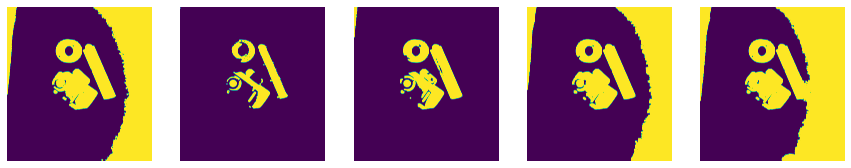

In [115]:
comp_amount, otsu, minim, li, iso, mean = find_comp_amount(0)
print("Компонент связности:", comp_amount)

fig, ax = plt.subplots(1, 5, figsize=(15,6))

ax[0].imshow(otsu)
ax[0].axis('off')

ax[1].imshow(minim)
ax[1].axis('off')

ax[2].imshow(li)
ax[2].axis('off')

ax[3].imshow(iso)
ax[3].axis('off')

ax[4].imshow(mean)
ax[4].axis('off')

Работает почти всегда плохо, потому что неравномерное освещение добавляет новых компонент. Пробовала локальзую бинаризацию, но не помогло. Надо будет как-то исправить.

Теперь нам необоходимо выявить шаблоны, котоые соотвествуют предметам с картинки. Оставим столько шаблонов, сколько компонент связности получилось. Наиболее подходящие выберем с помощью ransac.

In [107]:
def find_appr_templates(in_descriptors):
    num = []
    for i, template in enumerate(templates):
        matches = match_descriptors(in_descriptors, des[template], cross_check = True)
        src = kps[template][matches[:, 0]]
        dst = in_keypoints[matches[:, 1]]
        
        # ищем преобразование, переводящее как можно больше особых точек шаблона в соответствующие точки картинки
        _, inliers = ransac((src, dst), AffineTransform,
                            min_samples=min(3, len(src)-1), 
                            residual_threshold=2,
                            max_trials=2000)
        
        # считаем для шаблона количество особых точек, которые соответствуют построенной модели
        num.append([np.count_nonzero(inliers), template]) 
    
    num.sort(key = lambda a: a[0], reverse=True)
    # выбираем наиболее подходящие шаблоны
    appr_templates = num[:comp_amount]
    appr_templates = [elem[1] for elem in appr_templates]
    # сортируем в порядке убывания максимального измерения описывающего прямоугольника
    # нужно для геометрической части
    appr_templates.sort(key = lambda x: max_dim[x], reverse = True)
    return appr_templates

Проверим для нашего примера.

In [116]:
appr_templates = find_appr_templates(in_descriptors)
print(appr_templates)

['comb.png', 'ruler.png', 'scissors.png', 'disk.png', 'banana.png', 'camera.png']


Видно, что часть предметов нашлась правильно. Их получилось больше чем надо из-за неправильного подсчета компонент связности, а один предмет -- кольцо -- не нашелся совсем. На большинстве примеров находится правильно как раз 1-2 предмета.

# Попадание в многоугольник

Вспомогательные функции:

In [88]:
# функция считывает координаты прямоугольника из входных данных
def get_coords(number):
    coordinates = []
    with open(f'input/input{number}/coordinates.csv', 'r') as coords:
        for vertex in csv.reader(coords, delimiter=','):
            coordinates.append(np.int0(vertex).tolist())
    return coordinates        
        
# функция возвращает максимальное из измерений прямоугольника 
def get_max_dim(coordinates):    
    h = coordinates[1][1] - coordinates[0][1]
    w = coordinates[2][0] - coordinates[0][0]
    return max(h, w)

# функция возвращает минимальное из измерений прямоугольника 
def get_min_dim(coordinates):    
    h = coordinates[1][1] - coordinates[0][1]
    w = coordinates[2][0] - coordinates[0][0]
    return min(h, w)  

Пример:

In [117]:
coordinates = get_coords(0)
print(coordinates)

[[0, 0], [0, 1800], [1800, 1800], [1800, 0]]


In [90]:
!pip install pyclipper

In [91]:
import pyclipper

Функция проверяет, влезают ли объекты в прямоугольник. Работает пока довольно грубо: "прилаживает" самый большой (по величине максимального измерения) шаблонный прямоугольник длинной стороной сначала к короткой стороне большого прямоугольника. Если все влезает, то отрезаем от длинной стороны соответствующую полоску и берем следующий шаблон. Если не влезло, поворачиваем шаблонный прямоугольник на 90 градусов и пытаемся "приладить" к длинной стороне. Если получилось, отрезаем сооответствующую полоску от короткой стороны и продолжаем со следующим шаблоном. Если не получилось, значит, предмет не влез и можно возвращать 0.

In [119]:
def check_polygon(d1, d2, appr_templates):
    if len(appr_templates) == 0:
        return 1 
    max_poly_dim = max(d1, d2)
    min_poly_dim = min(d1, d2)
    for i in range(len(appr_templates)):
        template = appr_templates[i]
        temp = poly[template]
        
        max_templ_dim = get_max_dim(temp)
        min_templ_dim = get_min_dim(temp)
        
        if max_templ_dim <= min_poly_dim:
            max_poly_dim -= min_templ_dim
        elif max_templ_dim <= max_poly_dim and min_templ_dim <= min_poly_dim:
            min_poly_dim -= min_templ_dim
        else:
            return 0
    return 1

Проверим на примере:

In [118]:
d1 = get_max_dim(coordinates)
d2 = get_min_dim(coordinates)
print(appr_templates)
check_polygon(d1, d2, appr_templates)

['comb.png', 'ruler.png', 'scissors.png', 'disk.png', 'banana.png', 'camera.png']


1

Проверим для всех размеченных примеров.

In [120]:
answers = []
for i in range(26):
    edge_img, _, in_descriptors = find_kps_and_des(i)   
    comp_amount = find_comp_amount(i)[0]
    appr_templates = find_appr_templates(in_descriptors)
    coordinates = get_coords(i)
    d1 = get_max_dim(coordinates)
    d2 = get_min_dim(coordinates)
    answers.append(check_polygon(d1, d2, appr_templates))
    print(check_polygon(d1, d2, appr_templates))      

<ipython-input-73-87e5f018bcb4>:10: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img_blur_gray = rgb2gray(img_blur)


1
0
0
1
1
0
1
0
1
1
1
1
1
1
0
1
1
0
1
1
1
0
1
0
1
1


Сравним полученные значения с правильными ответами:

In [121]:
labels = []

with open('labels.csv', 'r') as fh:
    for line in csv.reader(fh, delimiter = '\t'):
        labels.append(line[1])
print(labels)        

['1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1', '1', '0', '0', '1', '0', '1', '0']


Посчитаем качество:

In [129]:
np.sum([answers[i] == int(labels[i]) for i in range(26)])/26

0.8076923076923077

Получилось нормальное качество, но это обусловлено скорее тем, что многоугольники мы брали простой фомы, а не тем, что алгоритм нормально работает, потому что матчинг и подсчет компонент связности работают плохо.

Следующие 2 ячейки для улучшения матчинга, но пока все тоже работает плохо. Оставляю, чтобы доработать, если получится.

In [ ]:
img_name = os.listdir('input')[1]
img = imread(f'input/{img_name}')

crops = os.listdir('crops')
crop = imread(f'crops/{crops[9]}')
#plt.imshow(crop)
best_ang = 0
best_corr = 0
corr = []
for ang in range(0, 360, 10):
        center = tuple(np.array(img.shape[1::-1]) / 2)
        r_img = rotate_image(img, center, ang)
#        correlation = skimage.feature.match_template(r_img, crop)
        correlation = cv2.matchTemplate(crop, r_img, cv2.TM_CCORR_NORMED)
        cur_corr = np.max(correlation)
        corr.append(cur_corr)
        print(ang, cur_corr)
        if cur_corr > best_corr:
            best_corr = cur_corr
            best_ang = ang
print(best_corr)      
plt.plot([10*i for i in range(36)], corr)



In [ ]:
img_name = os.listdir('input')[1]
img = imread(f'input/{img_name}')

crops = os.listdir('crops')
appr_templates = []
for crop_name in crops:
    crop = imread(f'crops/{crop_name}')
    max_corr = -1
    entropy = 0
    sum = 0
    corr = []
    for ang in range(0, 190, 10):
        center = tuple(np.array(img.shape[1::-1]) / 2)
        r_img = rotate_image(img, center, ang)
        correlation = cv2.matchTemplate(crop, r_img, cv2.TM_CCORR_NORMED) 
        cur_corr = np.max(correlation)
        corr.append(cur_corr)
        sum += cur_corr
    ent = [- (c/sum) * math.log(c/sum) for c in corr]
    entropy = np.sum(ent)
    print(entropy)                

#    if max_corr/min_corr > 1.4:
#        appr_templates.append(f'{crop_name}')
#print(appr_templates)        